# Today you are a Data Scientist at Tesla! 
## You have assigned a new project to look at car sales from Quarters 1-2 in California for 2019 to make predictions as to which cars will be sold more than the others in Q3 and Q4, to ensure enough inventory to meet demands!

### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the Q12 and Q34 sales data in the same Google Drive folder as this notebook.

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



### Import the necessary modules

In [1]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [2]:
df_sales = pd.read_csv("sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,...,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [3]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,...,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

The `'dealer_state'` and `'date'` columns have already been eliminated in this dataset, so you don't need to worry about them here. Examine the data's shape and first few rows.

In [4]:
### START CODE HERE ###
# Read in the Q34 data
df_pred = pd.read_csv("sales_Q34_2019.csv")
# Print the shape of the data
print(np.shape(df_pred))
# Examine the first few rows of the data
df_pred.head()
### END CODE HERE ###

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,...,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55370


# Task I. Consolidate data by finding numbers of unique car combinations sold for training and test data sets

You've probably noticed that 73 of the 74 columns in our Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. You've probably also noticed that the final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.

## This task requires data wrangling!
## Create functions that read the Q12 (df_sales) and Q34 (df_pred) data sets and create train_X, train_Y, test_X and test_Y, respectively. Use pandas and NumPy as needed.

train_X, test_X = unique row combinations without MSRP column

train_Y, test_Y = number of unique cars sold

In [5]:
def get_features_and_targets(df):
    ### START CODE HERE ###
    # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.drop(columns=['MSRP'])
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    # Make sure the counts are unsorted, so they're listed in order of the combination's first appearance
    # in the data DataFrame, and that the array is 2D, with 1 entry per row
    Y = np.array(data.value_counts(sort=False, normalize=True))[:, np.newaxis] 
    # Get a list of the column names of the data DataFrame
    subset_names = data.columns.values.tolist()
    # Use the drop_duplicates() method on the df DataFrame to store the features data as a NumPy array where
    # each row corresponds to a unique combination of 'main_type', 'engine', and 'sales_version' values
    # Make sure to set the subset parameter to subset_names, so the 'MSRP' column isn't included in the 
    # uniqueness calculations
    X = np.array(df.drop_duplicates(subset=subset_names))
    # Scale and shift the 'MSRP' column so its values fall in the range [0,1]
    # You might find NumPy's ptp() function useful
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
    # Return features and targets
    return X, Y
    ### END CODE HERE ###

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [6]:
### START CODE HERE ###
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)
# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)
### END CODE HERE ###
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


You probably noticed that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2? Let's find out.

In [7]:
# How many unique cars in 2012 (Q1:Q4)?
### START CODE HERE ### 
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])
# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)
### END CODE HERE ###
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


The following probability equations are true for any two events $A$ and $B$:

$$P (A \cup B) = P(A) + P(B) - P (A \cap B)$$
$$P(A) = P (A \cap B) + P (A \cap B^c)$$

Use them to determine how many car models were sold in both halves of 2019, how many were discontinued by the second half of the year, and how many were launched in the second half of the year.

In [8]:
### START CODE HERE ###
models_q12_or_q34 = len(data_Y)
models_q12 = len(train_Y)
models_q34 = len(test_Y)
models_q14 = models_q12 + models_q34 - models_q12_or_q34
discontinued = models_q12 - models_q14
launched = models_q34 - models_q14
#print(f"{models_q14} models were sold throughout 2019")
#print(f"{discontinued} models were discontinued by the second half of 2019")
#print(f"{launched} models were launched in the second half of 2019")
### END CODE HERE ###

# Task II: Visualize the training and test targets any way you see fit

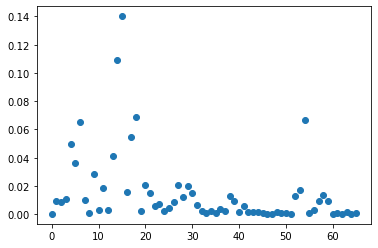

In [9]:
# Visualize the training targets
### START CODE HERE ###
plt.scatter(range(len(train_Y)), train_Y)
plt.show()
### END CODE HERE ###

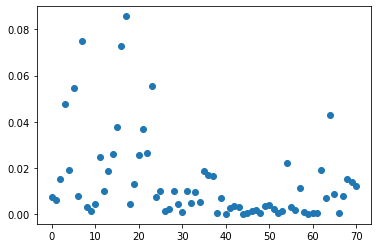

In [10]:
# Visualize the test targets
### START CODE HERE ###
plt.scatter(range(len(test_Y)), test_Y)
plt.show()
### END CODE HERE ###

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [11]:
# Initialize learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
s_max_iteration = 1000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [12]:
# Define your hypothesis function according to the instructions above
def h (theta, X) :
    ### START CODE HERE ###
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    #tempX = np.hstack([np.ones((len(X)))])
    # Return a matrix multiplication of your augmented X and theta
    #print('X: ', X.shape)
    #print('TempX: ', tempX.shape)
    #print('theta: ', theta.shape)
    return np.matmul(tempX, theta)
    ### END CODE HERE ###

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [13]:
# Loss Function
def loss (theta, X, Y) :
    ### START CODE HERE ###
    return np.average(np.square(Y-h(theta, X))) / 2
    ### END CODE HERE ###

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [24]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    # Create a temporary X array with an added 0th bias column
    #tempX = np.hstack(np.ones((len(X)+1, 1)), X)
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    m = len(X)
    X_transpose = tempX.transpose()
    Y_Y_hat = h(theta, X)
    # Compute the gradient according to the instructions above
    #d_theta = -1/m * np.dot(X_transpose, Y_Y_hat)
    d_theta = - np.dot(tempX.T, Y - h(theta, X)) / X.shape[0]
    ### END CODE HERE ###
    return d_theta

### Gradient Descent

Set up a function to train your linear regression model with gradient descent, i.e. calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. Recall that the general gradient descent update formula is $\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$. We've provided the skeleton of a stochastic gradient descent function, but you're welcome to experiment with batch and/or minibatch gradient descent. Also recall that the aforementioned gradient descent methods differ in how frequently they calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. 

In [72]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    ### START CODE HERE ###
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the dataset
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            #d_theta = gradient(theta, np.reshape(X[j], (1, X.shape[1])), np.reshape(Y[j], (1,1)))
            d_theta = gradient (theta, X[np.newaxis, j, :], Y[np.newaxis, j, :])
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update the cost array for the current iteration
        cost[i] = loss(theta, X, Y)
    ### END CODE HERE ###
        #if i % gap == 0 :
            #print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [26]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.0004206533214992532
iteration :  100  loss :  0.0002422983467552357
iteration :  200  loss :  0.00021788868167880283
iteration :  300  loss :  0.00020533288342740926
iteration :  400  loss :  0.0001977965398586177
iteration :  500  loss :  0.0001928641360536338
iteration :  600  loss :  0.0001894284804626956
iteration :  700  loss :  0.0001869169084424983
iteration :  800  loss :  0.00018500756875786405
iteration :  900  loss :  0.0001835079702943847


### Generate Predictions from Test Data

In [27]:
### START CODE HERE ###
GD_P = h(s_theta, test_X)
### END CODE HERE ###
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

### Visualize the predicted and actual test labels

RMSE, R2 using SGD= 0.000518924229453394 0.6939013195958599


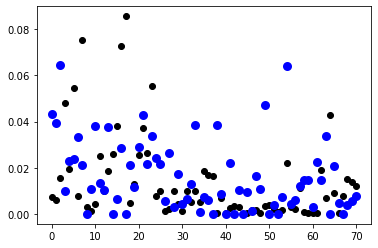

In [28]:
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


print("RMSE, R2 using SGD=", MSE(test_Y,GD_P), r2(test_Y,GD_P))

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = W^T \cdot X$$

and see how they compare to the predictions which we obtained from gradient descent.

In [35]:
### START CODE HERE ###
# Compute the inverse of the matrix product of the transpose of X and X
inv1 = np.linalg.pinv(np.dot(train_X.transpose(), train_X))
# Compute W using the first of the Normal Equations
W1 = np.dot(np.dot(inv1, train_X.transpose()), train_Y)
# Compute the predicted Y values using the second of the Normal Equations
PN1 = np.dot(test_X, W1)
### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

RMSE, R2 for prediction all features = 0.0005596570062877871 0.8479142625775198


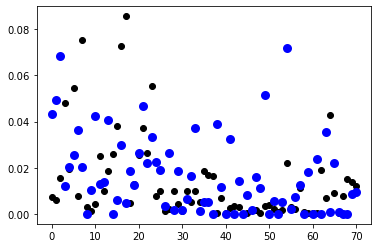

In [36]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]

### Regularized Normal Equations

In [37]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

Recall that our training features array train_X has
m = 66 rows and n = 74 columns


`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

RMSE, R2 for prediction all features = 0.00043227378115685356 0.2614195347874887


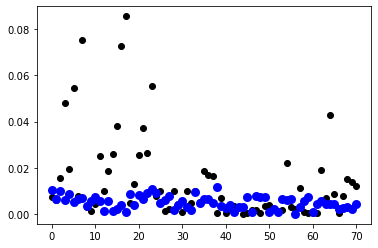

In [39]:
### START CODE HERE ###
l = 0.00005
n = train_X.shape[1]
m = len(train_X)
identity = np.identity(n)
invReg = np.linalg.pinv(np.dot(train_X.transpose(), train_X) + (1*m*identity))

W2 = np.dot(np.dot(invReg, train_X.transpose()), train_Y)
PN2 = np.dot(test_X, W2)
PN2[np.where(PN2<0)]=0
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN2)), PN2, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN2), r2(test_Y,PN2)) #[Low error high corr]
### END CODE HERE ###

# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [56]:
# GLM 
import statsmodels.api as sm
### START CODE HERE ###
# Instantiate the GLM
train_X_glm = sm.add_constant(train_X)
glm_gamma = sm.GLM(train_Y, train_X_glm, family=sm.families.Gamma())
# Train the GLM
glm_results = glm_gamma.fit()
### END CODE HERE ###
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                   Gamma   Df Model:                           31
Link Function:          inverse_power   Scale:                          151.64
Method:                          IRLS   Log-Likelihood:                 24.535
Date:                Sat, 24 Oct 2020   Deviance:                       91.058
Time:                        23:40:26   Pearson chi2:                 5.16e+03
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        858.9434   1.66e+04      0.052      0.9

/usr/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


### Generate predictions from the test data

In [57]:
### START CODE HERE ###
test_X_glm = sm.add_constant(test_X)
G_P = glm_results.predict(test_X_glm)
### END CODE HERE ###
# Set any negative predictions to 0
G_P[G_P<0]=0

RMSE, R2 for GLM= 0.000812292822095221 1.3713230464323383


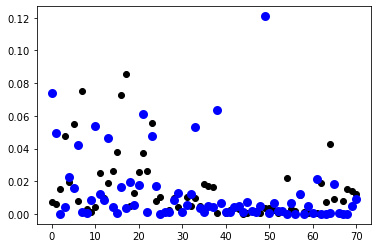

In [58]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("RMSE, R2 for GLM=", MSE(test_Y,G_P), r2(test_Y,G_P)) 

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

In [59]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestRegressor
# Instantiate the random forest regression model
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=5)
# Train the model
regr.fit(train_X, train_Y)
# Generate predictions from the test data
pred_rf = regr.predict(test_X)
### END CODE HERE ###

<ipython-input-59-f8e524ef7a69>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(train_X, train_Y)


In [60]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

RMSE, R2 for Decision Trees= 0.0006541515043448475 0.9230631521478815


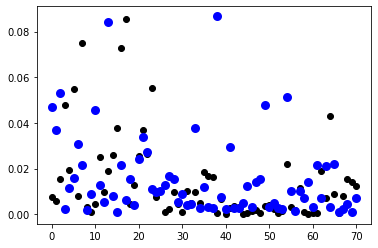

In [61]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf)) #[Low error high corr]

## Populate the table below with the results of your experiments above. Which models performed best?

## Results
---------------------------------------------------------------------------
Method                                          |  RMSE             | R2               |
------------------------------------------------|-------------------|------------------|
Gradient Descent:                            | 0.000518924229453394 | 0.6939013195958599 |
Normal Equations                             | 0.0005596570062877871 | 0.8479142625775198 |
Regularized Normal Equations                 | 0.00043227378115685356 | 0.2614195347874887 |
GLM                                          | 0.000812292822095221   | 1.3713230464323383 |
Decision Trees                               | 0.0006541515043448475  | 0.9230631521478815 |


The Regularized Normal Equations did the best with GLM doing the worst

## Finally, pick some car types for which your models over- and under-predicted sales. Attempt to determine the root causes. Write your findings below.

The models tended to over predict the first 20 models in the charts and underpredict the later ones.  This may be because some of them are newer and we did not have sufficient data available in the first half of the year to adequately predict the popularity of them.

### Extra Credit
For the Data Science Problem for Tesla, run hyper-parameterization set up to find the optimal parameters for the best regression model. Do this for at least 2 data models and report your results.

In [65]:
# Divide the training data (Q12 of car sales)
# into training and validation either randomly or based on the date of orders.
from sklearn.model_selection import train_test_split

X_train, x_valid = train_test_split(df_sales)

# then process each of these as above
train_X, train_Y = get_features_and_targets(X_train)
valid_x, valid_Y = get_features_and_targets(x_valid)

In [76]:
# Set a range for the hyper-parameters
# (e.g. number of iterations, s_theta etc for gradient descent, or 
# Lambda values for regularized Normal equations, or different 
# parameter settings for decision trees)
alphas = [.000001, .000003, .00001, .00003, .0001, .0003, .001, .003, .01, .03, .1, .3]
iterations = [500, 1000, 5000, 10000, 15000]
lambdas = [.00005, .0001, .0005, .001, .005, .01, .05, .1, .5, 1]

In [78]:
# Loop through the different hyper parameters
# to find which hyper-parameter set minimizes error on validation data.
# Fix the best hyper-parameter set as the one that yields min validation error.

# Looping gradient descent with different alphas
s_theta = np.zeros((train_X.shape[1]+1, 1))
alpha = .001
s_max_iteration = 1000

for num in alphas:
    print('ALPHA: ', num)
    new_theta, new_cost = stochastic_gradient_descent (s_theta, train_X, train_Y, num, s_max_iteration, 100)
    GD_P = h(new_theta, valid_x)
    # Set any negative predictions to 0
    GD_P[GD_P<0] = 0
    print("RMSE, R2 using SGD=", MSE(valid_Y,GD_P), r2(valid_Y,GD_P))
    

ALPHA:  1e-06
RMSE, R2 using SGD= 0.0009946185477497618 0.3743215269542506
ALPHA:  3e-06
RMSE, R2 using SGD= 0.0009228586365104952 0.2709354926745857
ALPHA:  1e-05
RMSE, R2 using SGD= 0.0008033103464220806 0.09634582058341203
ALPHA:  3e-05
RMSE, R2 using SGD= 0.0007586882096688616 0.02805499643764027
ALPHA:  0.0001
RMSE, R2 using SGD= 0.0007922965918050722 0.07875312939908433
ALPHA:  0.0003
RMSE, R2 using SGD= 0.0008426553657087668 0.1640263700991576
ALPHA:  0.001
RMSE, R2 using SGD= 0.0008722995909224353 0.24064499024279123
ALPHA:  0.003
RMSE, R2 using SGD= 0.0008806438628540514 0.27451130161019466
ALPHA:  0.01
RMSE, R2 using SGD= 0.000883395901126933 0.2823135841697331
ALPHA:  0.03
RMSE, R2 using SGD= 0.0008900207154487455 0.2770117095183341
ALPHA:  0.1
RMSE, R2 using SGD= 0.0009030201535678162 0.23513758938656404
ALPHA:  0.3
RMSE, R2 using SGD= 0.0010529126104629374 0.3980250371359223


Best alpha: .00003

In [79]:
alpha = 0.001
for num in iterations:
    print('ITERATION: ', num)
    new_theta, new_cost = stochastic_gradient_descent (s_theta, train_X, train_Y, alpha, num, 100)
    GD_P = h(new_theta, valid_x)
    # Set any negative predictions to 0
    GD_P[GD_P<0] = 0
    print("RMSE, R2 using SGD=", MSE(valid_Y,GD_P), r2(valid_Y,GD_P))

ITERATION:  500
RMSE, R2 using SGD= 0.0008576793022441572 0.19947422680681492
ITERATION:  1000
RMSE, R2 using SGD= 0.0008722995909224353 0.24064499024279123
ITERATION:  5000
RMSE, R2 using SGD= 0.0008799793932710414 0.2807811457851237
ITERATION:  10000
RMSE, R2 using SGD= 0.0008797482063763279 0.2831287499064609
ITERATION:  15000
RMSE, R2 using SGD= 0.000879532804844081 0.2832830245477934


Best iterations: 500

In [82]:
for num in lambdas:
    print('LAMBDA: ', num)
    n = train_X.shape[1]
    m = len(train_X)
    identity = np.identity(n)
    invReg = np.linalg.pinv(np.dot(train_X.transpose(), train_X) + (num*m*identity))

    W2 = np.dot(np.dot(invReg, train_X.transpose()), train_Y)
    PN2 = np.dot(valid_x, W2)
    PN2[np.where(PN2<0)]=0
    print("RMSE, R2 for prediction all features =", MSE(valid_Y,PN2), r2(valid_Y,PN2)) #[Low error high corr]

LAMBDA:  5e-05
RMSE, R2 for prediction all features = 0.0008765933614562131 0.28434851726241633
LAMBDA:  0.0001
RMSE, R2 for prediction all features = 0.0008764860055265335 0.28376635202651407
LAMBDA:  0.0005
RMSE, R2 for prediction all features = 0.0008756260956388889 0.27932166809728887
LAMBDA:  0.001
RMSE, R2 for prediction all features = 0.000874551777868698 0.274210858349566
LAMBDA:  0.005
RMSE, R2 for prediction all features = 0.0008664843526284891 0.2431955942432698
LAMBDA:  0.01
RMSE, R2 for prediction all features = 0.0008585673785278687 0.21766473210132656
LAMBDA:  0.05
RMSE, R2 for prediction all features = 0.0008312231976209534 0.14034561562813874
LAMBDA:  0.1
RMSE, R2 for prediction all features = 0.0008241955936597479 0.1170426474702844
LAMBDA:  0.5
RMSE, R2 for prediction all features = 0.0008637967713636686 0.16632687962449824
LAMBDA:  1
RMSE, R2 for prediction all features = 0.000908198634586881 0.2347668212610643


Best labmda: 0.1

In [74]:
# Apply the best hyperparameters on test data and report improvements
#    in terms of MSE and R2 metric.

In [84]:
new_theta, new_cost = stochastic_gradient_descent (s_theta, train_X, train_Y, .00003, 500, 100)
GD_P = h(new_theta, test_X)
# Set any negative predictions to 0
GD_P[GD_P<0] = 0
print("RMSE, R2 using SGD=", MSE(test_Y,GD_P), r2(test_Y,GD_P))

RMSE, R2 using SGD= 0.00035275507020458797 0.02300956738958031


In [85]:
n = train_X.shape[1]
m = len(train_X)
identity = np.identity(n)
invReg = np.linalg.pinv(np.dot(train_X.transpose(), train_X) + (0.1*m*identity))

W2 = np.dot(np.dot(invReg, train_X.transpose()), train_Y)
PN2 = np.dot(test_X, W2)
PN2[np.where(PN2<0)]=0
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN2), r2(test_Y,PN2)) #[Low error high corr]

RMSE, R2 for prediction all features = 0.0003951941386368768 0.15397147037105383


## Results
---------------------------------------------------------------------------
Method                                          |  RMSE             | R2               |
------------------------------------------------|-------------------|------------------|
Gradient Descent:                            | 0.000518924229453394 | 0.6939013195958599 |
GD w/ alpha and iterations changed             | 0.00035275507020458797 | 0.02300956738958031 |
Normal Equations                             | 0.0005596570062877871 | 0.8479142625775198 |
Regularized Normal Equations                 | 0.00043227378115685356 | 0.2614195347874887 |
RNE w/ lambda changed                           | 0.0003951941386368768 | 0.15397147037105383 |
GLM                                          | 0.000812292822095221   | 1.3713230464323383 |
Decision Trees                               | 0.0006541515043448475  | 0.9230631521478815 |